In [1]:
import cv2
import glob
import math
import sys 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import GlobalAveragePooling2D
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps

from google.colab import drive
drive.mount('/content/drive')

!\rm -rf train/
!\rm -rf test/

!\cp -f /content/drive/My\ Drive/Colab\ Notebooks/train.zip .
!\cp -f /content/drive/My\ Drive/Colab\ Notebooks/test.zip .
!\cp -f /content/drive/My\ Drive/Colab\ Notebooks/train_master.tsv .
!\cp -f /content/drive/My\ Drive/Colab\ Notebooks/sample_submit.tsv .
!unzip -oq train.zip
!unzip -oq test.zip
!mkdir -p test/all
!mv test/*.jpeg test/all/

train_dir = 'train/'

df = pd.read_csv('train_master.tsv') # なぜかCSV形式 :-)
df_test = pd.read_table('sample_submit.tsv')

# 画像サイズ
#input_width = 4032
#input_height = 3024
#input_width = 252
#input_height = 189
input_width = 252
input_height = 252
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,file_name,flag
0,bridge_000.jpeg,1
1,bridge_001.jpeg,1
2,bridge_002.jpeg,1
3,bridge_003.jpeg,1
4,bridge_004.jpeg,1
...,...,...
285,regular_095.jpeg,0
286,regular_096.jpeg,0
287,regular_097.jpeg,0
288,regular_098.jpeg,0


In [2]:
# Equalize color image
def equalize_color(img):
    img = img.convert("YCbCr")
    yy, cb, cr = img.split()
    yy = ImageOps.equalize(yy);
    img = Image.merge("YCbCr", (yy, cb, cr))
    img = img.convert("RGB")
    return img

# グレースケール化
def to_grayscale(path):
    img = cv2.imread(path)
    grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return grayed

# matplotlibで表示できるようにカラーの順番を変更する
def to_matplotlib_format(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## グレースケール化＋閾値処理
def binary_threshold(path):
    img = cv2.imread(path)
    grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    under_thresh = 100
    #upper_thresh = 255
    maxValue = 255
    th, drop_back = cv2.threshold(grayed, under_thresh, maxValue, cv2.THRESH_BINARY)
    #th, clarify_born = cv2.threshold(grayed, upper_thresh, maxValue, cv2.THRESH_BINARY_INV)
    #merged = np.minimum(drop_back, clarify_born)
    return drop_back

## 平滑化(スムージング)
def blur(img):
    filtered = cv2.GaussianBlur(img, (31, 31), 0)
    return filtered

def morph_and_blur(img):
    kernel = np.ones((3, 3),np.uint8)
    m = cv2.GaussianBlur(img, (3, 3), 0)
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN, kernel, iterations=2)
    m = cv2.GaussianBlur(m, (5, 5), 0)
    return m
    
def padding_position(x, y, w, h, p):
    return x - p, y - p, w + p * 2, h + p * 2

def detect_and_resize(path):
    contoured = cv2.imread(path)
    forcrop = cv2.imread(path)

    # make binary image
    birds = binary_threshold(path)
    birds = cv2.bitwise_not(birds)

    # detect contour
    contours, hierarchy = cv2.findContours(birds, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    c = max(contours, key=lambda x: cv2.contourArea(x))

    # rectangle area
    x, y, w, h = cv2.boundingRect(c)
    #x, y, w, h = padding_position(x, y, w, h, 5)
    if(h > w):
        size = h
        limit = w
    else:
        size = w
        limit = h
    start = int((size - limit) / 2)
    fin = int((size + limit) / 2)
    #new_img = cv2.resize(np.zeros((1, 1, 3), np.uint8), (size, size))
    new_img = cv2.resize(np.ones((1, 1, 3), np.uint8)*255, (size, size))
    if(size == h):
        new_img[:, start:fin] = forcrop[y:(y + h), x:(x + w)]
    else:
        new_img[start:fin, :] = forcrop[y:(y + h), x:(x + w)]
    img_cv = cv2.resize(new_img,(input_width, input_height))
    #plt.imshow(img_cv)
    # TODO start
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    img_cv = cv2.equalizeHist(img_cv)
    # TODO end
    cv2.imwrite(path,img_cv)
    
    # 真ん中を白くする(画像内の解析不要部分の消去)＋枚数調整
    if not 'test' in path:
        if 'bridge' in path:
            img_cv[input_width*2//5:input_width*3//5, input_width*2//5:input_width*3//5] = 255
            cv2.imwrite(path.replace('.jpeg', '_hole3.jpeg'),img_cv)
            img_cv[input_width*4//11:input_width*7//11, input_width*4//11:input_width*7//11] = 255
            cv2.imwrite(path.replace('.jpeg', '_hole2.jpeg'),img_cv)
            img_cv[input_width//3:input_width*2//3, input_width//3:input_width*2//3] = 255
            cv2.imwrite(path.replace('.jpeg', '_hole.jpeg'),img_cv)
        elif 'horn' in path and (path[-6:] == "3.jpeg" or path[-6:] == "4.jpeg" or path[-6:] == "5.jpeg"):
            img_cv[input_width*2//5:input_width*3//5, input_width*2//5:input_width*3//5] = 255
            cv2.imwrite(path.replace('.jpeg', '_hole3.jpeg'),img_cv)
            img_cv[input_width*4//11:input_width*7//11, input_width*4//11:input_width*7//11] = 255
            cv2.imwrite(path.replace('.jpeg', '_hole2.jpeg'),img_cv)
            img_cv[input_width//3:input_width*2//3, input_width//3:input_width*2//3] = 255
            cv2.imwrite(path.replace('.jpeg', '_hole.jpeg'),img_cv)
        elif path[-6:] == "0.jpeg":
            img_cv[input_width//3:input_width*2//3, input_width//3:input_width*2//3] = 255
            cv2.imwrite(path.replace('.jpeg', '_hole.jpeg'),img_cv)
        elif path[-6:] == "1.jpeg":
            img_cv[input_width*2//5:input_width*3//5, input_width*2//5:input_width*3//5] = 255
            cv2.imwrite(path.replace('.jpeg', '_hole2.jpeg'),img_cv)
        elif path[-6:] == "2.jpeg":
            img_cv[input_width*4//11:input_width*7//11, input_width*4//11:input_width*7//11] = 255
            cv2.imwrite(path.replace('.jpeg', '_hole3.jpeg'),img_cv)


In [3]:
files = glob.glob("train/*/*")
for file in files:
    detect_and_resize(file)

files = glob.glob("test/all/*")
for file in files:
    detect_and_resize(file)

In [4]:
'''
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=12, n_init=10)
data = []
files = glob.glob("train/*/*")
for file in files:
# 画像を読み出して、サイズを変更して、1次元にする 
    res = cv2.resize(cv2.imread(file), (252, 252)).reshape((-1))
    data.append(res)
k_means.fit(np.array(data))
print(k_means.labels_)
'''

'\nfrom sklearn.cluster import KMeans\n\nk_means = KMeans(n_clusters=12, n_init=10)\ndata = []\nfiles = glob.glob("train/*/*")\nfor file in files:\n# 画像を読み出して、サイズを変更して、1次元にする \n    res = cv2.resize(cv2.imread(file), (252, 252)).reshape((-1))\n    data.append(res)\nk_means.fit(np.array(data))\nprint(k_means.labels_)\n'

In [5]:
#Image.open('train/bridge/bridge_017_hole3.jpeg')

In [6]:
#Image.open('train/bridge/bridge_017_hole.jpeg')

In [7]:
from PIL import Image, ImageOps
files = glob.glob("train/*/*")
for file in files:
    img = Image.open(file)
    '''
    img = img.convert(mode="L") 
    img = img.point(lambda x: 255 if x > 200 else x) 
    img = ImageOps.equalize(img)
    img = equalize_color(img)
    img.save(file)
    '''

    img.rotate(90).save(file.replace('.jpeg', '_rotate_90.jpeg'))
    img.rotate(180).save(file.replace('.jpeg', '_rotate_180.jpeg'))
    img.rotate(270).save(file.replace('.jpeg', '_rotate_270.jpeg'))

In [8]:
files = glob.glob("train/*/*")
for file in files:
    if 'bridge' in file:
        img = Image.open(file)
        ImageOps.mirror(img).save(file.replace('.jpeg', '_mirror.jpeg'))

'''
files = glob.glob("test/*/*")
for file in files:
    img = Image.open(file)
    img = img.convert(mode="L") 
    img = img.point(lambda x: 255 if x > 200 else x) 
    img = ImageOps.equalize(img)
    img = equalize_color(img)
    img.save(file)
'''


'\nfiles = glob.glob("test/*/*")\nfor file in files:\n    img = Image.open(file)\n    img = img.convert(mode="L") \n    img = img.point(lambda x: 255 if x > 200 else x) \n    img = ImageOps.equalize(img)\n    img = equalize_color(img)\n    img.save(file)\n'

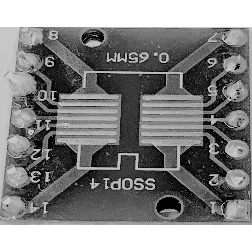

In [9]:
from PIL import Image, ImageOps
Image.open('train/potato/potato_086.jpeg')

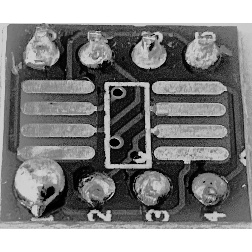

In [10]:
Image.open('train/potato/potato_088.jpeg')

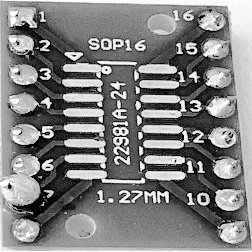

In [11]:
Image.open('train/potato/potato_089.jpeg')

In [12]:
#Image.open('train/bridge/bridge_001_hole2.jpeg')

In [13]:
!ls -la /content/train/bridge/

total 19440
drwxr-xr-x 2 root root 69632 Oct 21 23:57 .
drwxr-xr-x 6 root root  4096 Sep 14 19:25 ..
-rw-r--r-- 1 root root 37595 Oct 21 23:54 bridge_000_hole2.jpeg
-rw-r--r-- 1 root root 18183 Oct 21 23:57 bridge_000_hole2_mirror.jpeg
-rw-r--r-- 1 root root 18169 Oct 21 23:57 bridge_000_hole2_rotate_180.jpeg
-rw-r--r-- 1 root root 18531 Oct 21 23:57 bridge_000_hole2_rotate_180_mirror.jpeg
-rw-r--r-- 1 root root 18161 Oct 21 23:57 bridge_000_hole2_rotate_270.jpeg
-rw-r--r-- 1 root root 18569 Oct 21 23:57 bridge_000_hole2_rotate_270_mirror.jpeg
-rw-r--r-- 1 root root 18206 Oct 21 23:57 bridge_000_hole2_rotate_90.jpeg
-rw-r--r-- 1 root root 18673 Oct 21 23:57 bridge_000_hole2_rotate_90_mirror.jpeg
-rw-r--r-- 1 root root 39226 Oct 21 23:54 bridge_000_hole3.jpeg
-rw-r--r-- 1 root root 18767 Oct 21 23:57 bridge_000_hole3_mirror.jpeg
-rw-r--r-- 1 root root 18634 Oct 21 23:57 bridge_000_hole3_rotate_180.jpeg
-rw-r--r-- 1 root root 19186 Oct 21 23:57 bridge_000_hole3_rotate_180_mirror.jpeg
-rw

In [20]:
from keras.layers import Input, Flatten, Dense
from keras.applications.resnet50 import ResNet50
from keras.applications import ResNet152V2
from keras.applications import ResNet50V2
from keras.models import Sequential, Model

# 回転や拡大縮小によりデータ数を水増し
image_generator = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2)
'''
image_generator = ImageDataGenerator(validation_split=0.2)
'''
# 学習用データ読込み
train_generator = image_generator.flow_from_directory(
        train_dir,
        target_size=(input_width, input_height),
        batch_size=5,
        shuffle=True,
        #color_mode = 'rgb',
        subset="training",
        class_mode='categorical')
#        class_mode='binary')

# 訓練時検証用データ読込み
validation_generator = image_generator.flow_from_directory(
        train_dir,
        target_size=(input_width, input_height),
        batch_size=5,
        shuffle=True,
        #color_mode = 'rgb',
        subset="validation",
        class_mode='categorical')
#        class_mode='binary')


'''
# 畳み込みニューラルネットワーク
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(input_width, input_height, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dense(1, activation='sigmoid'))
model.add(layers.Dense(4, activation='softmax'))
#model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])
'''

'''
input_tensor = Input(shape=(input_width, input_height, 3))
resNet50 = ResNet50(include_top=False, weights='imagenet',input_tensor=input_tensor)
#resNet50 = ResNet50(include_top=True, weights='imagenet',input_tensor=input_tensor)
top_model = Sequential()
top_model.add(Flatten(input_shape=resNet50.output_shape[1:]))
top_model.add(Dense(4, activation='softmax'))
model = Model(inputs=resNet50.input, outputs=top_model(resNet50.output))
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])
'''
'''
inception_model = ResNet152V2(
    include_top=True, weights='imagenet', input_tensor=None,
    pooling=None, classes=1000, classifier_activation='softmax'
)

# Enable Training of resnet
for layer in inception_model.layers:
    layer.trainable = True

model = Sequential()
model.add(inception_model.layers[-2])
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])
'''

model = ResNet152V2(
    include_top=True,
    weights=None,
    input_shape=(input_width, input_height, 3),
    classifier_activation="softmax",
    classes=4
)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])
model.summary()

Found 2033 images belonging to 4 classes.
Found 507 images belonging to 4 classes.
Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 252, 252, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 258, 258, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 126, 126, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 128, 128, 64) 0           conv1_conv[0][0]                 
_____

In [ ]:
'''
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      #epochs=200,
      validation_data=validation_generator,
      validation_steps=20, verbose=2)
'''
history = model.fit(
      train_generator,
      epochs=500,
      validation_data=validation_generator,
      verbose=2)

# 処理時間が長いため途中から再開できるようできた学習モデルを保存しておく
model.save('PBL_03')

Epoch 1/500
407/407 - 89s - loss: 1.4032 - accuracy: 0.3615 - val_loss: 3.5006 - val_accuracy: 0.3767
Epoch 2/500
407/407 - 87s - loss: 1.2879 - accuracy: 0.4319 - val_loss: 2.6950 - val_accuracy: 0.2564
Epoch 3/500
407/407 - 87s - loss: 1.2691 - accuracy: 0.4555 - val_loss: 1.6711 - val_accuracy: 0.3866
Epoch 4/500
407/407 - 87s - loss: 1.1516 - accuracy: 0.5061 - val_loss: 1.6287 - val_accuracy: 0.3708
Epoch 5/500
407/407 - 87s - loss: 1.1094 - accuracy: 0.5243 - val_loss: 1.6545 - val_accuracy: 0.4043
Epoch 6/500
407/407 - 87s - loss: 1.0547 - accuracy: 0.5489 - val_loss: 2.2027 - val_accuracy: 0.2564
Epoch 7/500


In [ ]:
test_dir = 'test/'
df_test = pd.read_table('sample_submit.tsv')

model = load_model('PBL_03')     

test_datagen = ImageDataGenerator(rescale=1./255,
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
'''
test_datagen = ImageDataGenerator()
'''
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(input_width,input_height),
    batch_size=1,
    class_mode='categorical')
#        class_mode='binary')

pred = model.predict(test_generator)


In [ ]:
print(np.round(pred*100))